# Imports

In [1]:
import sys
sys.path.append("/mnt/d/00_SARDARCHITECTLABS/projects/fscoreai-ml/")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from fscoreai.utils import utils
from fscoreai.loss import loss
from fscoreai.sample_data import sample_data

In [3]:
from sklearn.preprocessing import normalize
from sklearn.linear_model import LinearRegression

# One-Dimensional Data

In [4]:
X, y = sample_data.simulate_linear_data()
X = X[:, 0].reshape(-1, 1)
y = y.reshape(-1)
print(X.shape, y.shape)

(100, 1) (100,)


## SimpleLinear Regression with SkLearn

In [5]:
model_sklearn = LinearRegression(fit_intercept=True)
model_sklearn.fit(X,y)
print(model_sklearn.coef_, model_sklearn.intercept_)

[2.06896634] 0.9135935729613112


## Custom Simple Linear Regression

In [6]:
class SimpleLinearRegression():
    def __init__(self):
        self.coef_ = 0
        self.intercept_ = 0
    
    def fit_stat(self, X, y):
        # Closed-form Solution
            X_mean = np.mean(X, axis=0)
            y_mean = np.mean(y)
            self.coef_ = np.sum((X - X_mean).T*(y-y_mean), axis=1)/(np.sum((X - X_mean)**2, axis=0)) 
            self.intercept_ = y_mean - (self.coef_ * X_mean)
            return self
    
    def fit_grad(self, X, y, lr=1e-8, epochs=50):
        # Batch Gradient Descent Solution
            self.lr = lr  #   Learning rate
            self.epochs = epochs
            self.n, self.d = X.shape
            
            for epoch in range(self.epochs):
                for j in range(self.d):
                    y_pred = self.predict(X)
                    d_coef = - (2 / self.n) * np.sum((y - y_pred).dot(X[:,j])) #Derivative w.r.t. self.coef_
                    d_intercept = - (2 / self.n) * np.sum(y - y_pred) #Derivative w.r.t. self.intercept_
                    self.coef_ -=  self.lr * d_coef          #    Update self.coef_ 
                    self.intercept_ -=  self.lr * d_intercept  #    Update self.intercept_
            return self
        
    def predict(self, X):
        return np.dot(X, self.coef_) + self.intercept_

In [7]:
# Using Closed-form Solution
model_fscore_1 = SimpleLinearRegression()
model_fscore_1.fit_stat(X,y)
print(model_fscore_1.coef_, model_fscore_1.intercept_)

[2.06896634] [0.91359357]


In [8]:
# Using Batch Gradient Descent Solution
model_fscore_2 = SimpleLinearRegression()
model_fscore_2.fit_grad(X,y,lr=1e-6, epochs=10000)
print(model_fscore_2.coef_, model_fscore_2.intercept_)

1.0225567627664385 1.341525646728117


## Plotting the models

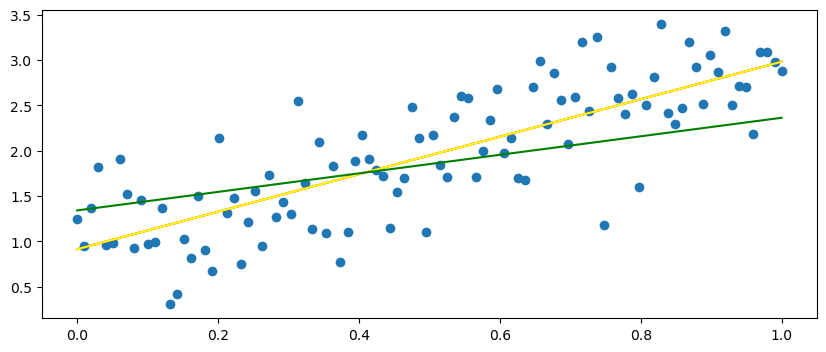

In [9]:
preds_sklearn = model_sklearn.predict(X)
preds_fscore_1 = model_fscore_1.predict(X)
preds_fscore_2 = model_fscore_2.predict(X)

plt.figure(figsize=(10,4))
plt.scatter(X, y)
plt.plot(X, preds_sklearn, color='red')
plt.plot(X, preds_fscore_1, color='yellow')
plt.plot(X, preds_fscore_2, color='green')

plt.show()

# Multi-Dimensional Data

In [10]:
X, y = sample_data.diabetes_data()

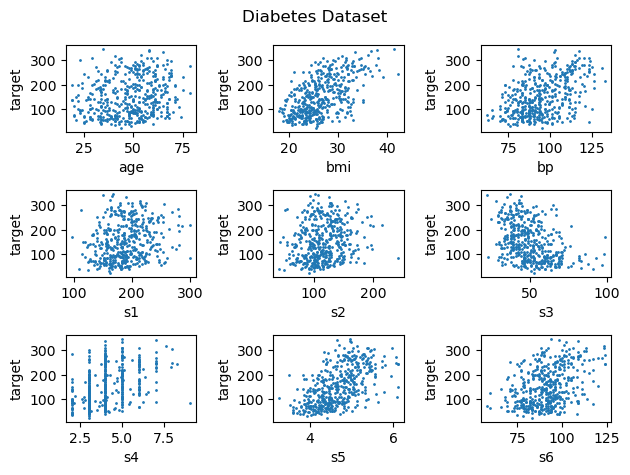

In [11]:
# Don't plot the sex data
X = X.drop(columns='sex')
features = X.columns

# Plot
fig, axs = plt.subplots(3, 3)
fig.suptitle('Diabetes Dataset')
for i in range(3):
    for j in range(3):
        n = j + i * 3
        feature = features[n]
        axs[i, j].scatter(X[feature], y, s=1)
        axs[i, j].set_xlabel(feature)
        axs[i, j].set_ylabel('target')
plt.tight_layout()
plt.show()

## Multiple Linear Regression with SkLearn

In [12]:
X, y = X.to_numpy(), y.to_numpy()

In [13]:
# SkLearn for Comparision
model_sklearn = LinearRegression(fit_intercept=True)
model_sklearn.fit(X,y)
print("Coef_:\n", model_sklearn.coef_)
print("\nIntercept_:\n", model_sklearn.intercept_)
print("\nMSE:\n",loss.mean_squared_error(y, model_sklearn.predict(X)))

Coef_:
 [[-0.12051511  6.00406612  0.95050794 -0.98078427  0.65849619  0.51362821
   4.65988116 68.9473421   0.2026253 ]]

Intercept_:
 [-363.89871603]

MSE:
 2961.503376648679


## Custom Multiple Linear Regression

In [14]:
class MultipleLinearRegression():
    def __init__(self):
        self.betas = None
        self.coef_ = None
        self.intercept_ = None
        
        self.betas_history = {}
        self.loss_history = {}
        self.gradients_history = {}
    
    def fit_stat(self, X, y):
        # Closed-form Solution
        self.n, self.d = X.shape
        x_0 = np.ones((self.n, 1))
        x = np.hstack((x_0, X))
        self.betas = np.linalg.inv(np.dot(x.T, x)).dot(np.dot(x.T, y))

        self.intercept_ = self.betas[0]
        self.coef_ = self.betas[1:]
        return self
    
    def fit_grad(self, X, y, lr, iters, regularization=False):
        # Batch Gradient Descent Solution
        reg = 0
        if regularization:
            reg = 0.1
        y = y.reshape(-1, 1)
        self.n, self.d = X.shape
        x_0 = np.ones((self.n, 1))
        x = np.hstack((x_0, X))

        # Initialize betas
        self.betas = np.random.randn(self.d + 1, 1)

        for i in range(iters):
            y_pred = np.dot(x, self.betas)
            delta_betas = 2 * np.dot(x.T, (y_pred - y)) + reg * self.betas
            self.betas -= (lr * delta_betas)

            # Logging Loss
            self.gradients_history[i] = delta_betas
            b = self.betas.copy()
            self.betas_history[i] = b
            self.loss_history[i] = loss.mean_squared_error(y_pred, y)

        self.intercept_ = self.betas[0]
        self.coef_ = self.betas[1:]
        return self
        
    def predict(self, X):
        x_0 = np.ones((X.shape[0], 1))
        x = np.hstack((x_0, X))
        return np.dot(x, self.betas)

In [15]:
# Closed-form solution
model_fscore_1 = MultipleLinearRegression()
model_fscore_1.fit_stat(X,y)
print("Coef_:\n", model_fscore_1.coef_)
print("\nIntercept_:\n", model_fscore_1.intercept_)
print("\nMSE:\n",loss.mean_squared_error(y, model_fscore_1.predict(X)))

Coef_:
 [[-0.12051511]
 [ 6.00406612]
 [ 0.95050794]
 [-0.98078427]
 [ 0.65849619]
 [ 0.51362821]
 [ 4.65988116]
 [68.9473421 ]
 [ 0.2026253 ]]

Intercept_:
 [-363.89871603]

MSE:
 2961.5033766486795


# Linear Regression Batch Gradient Descent Analysis

In [16]:
model = MultipleLinearRegression()
model.fit_grad(X, y, lr=1e-8, iters=100000, regularization=False)
print("Coef_:\n", model.coef_)
print("\nIntercept_:\n", model.intercept_)
print("\nMSE:\n",loss.mean_squared_error(y, model.predict(X)))

Coef_:
 [[-0.06512426]
 [ 5.62067538]
 [ 0.78485446]
 [ 1.47895593]
 [-1.62042015]
 [-2.79109449]
 [-0.91121236]
 [-1.17712843]
 [-0.12591859]]

Intercept_:
 [0.45144754]

MSE:
 3175.392929564334


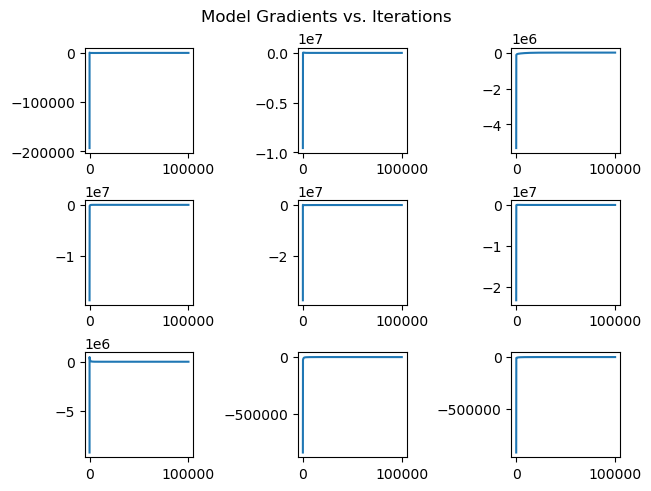

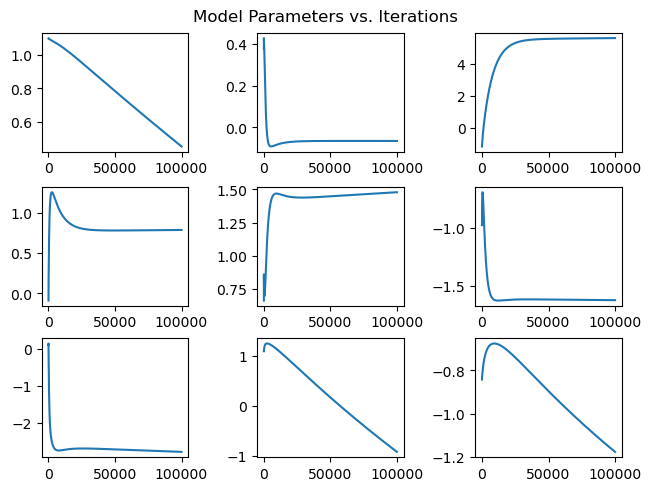

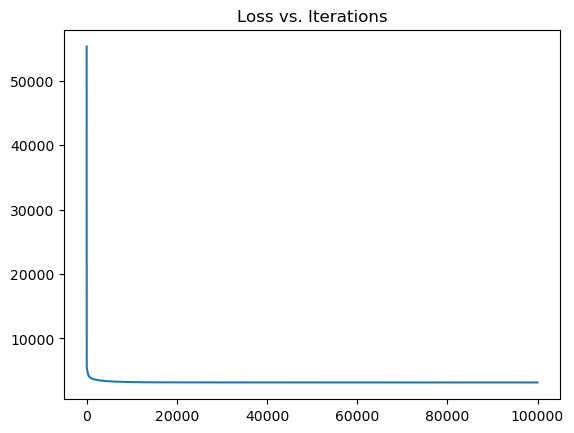

In [17]:
# Logging and visualizing stored training data
model_betas = np.array(list(model.betas_history.values()))
model_gradients = np.array(list(model.gradients_history.values()))
model_loss = np.array(list(model.loss_history.values()))

# Visualize Model Gradients
fig, axs = plt.subplots(3,3,constrained_layout=True)
fig.suptitle('Model Gradients vs. Iterations')
for i in range(3):
    for j in range(3):
        n = j + i * 3
        axs[i][j].plot(model.gradients_history.keys(), model_gradients[:, n])
plt.show()

# Visualize Model Parameters
fig, axs = plt.subplots(3, 3, constrained_layout = True)
fig.suptitle('Model Parameters vs. Iterations')
for i in range(3):
    for j in range(3):
        n = j + i * 3
        axs[i][j].plot(model.betas_history.keys(), model_betas[:, n])
plt.show()

# Visualize Model Loss
plt.plot(model.loss_history.keys(), model_loss)
plt.title("Loss vs. Iterations")
plt.show()

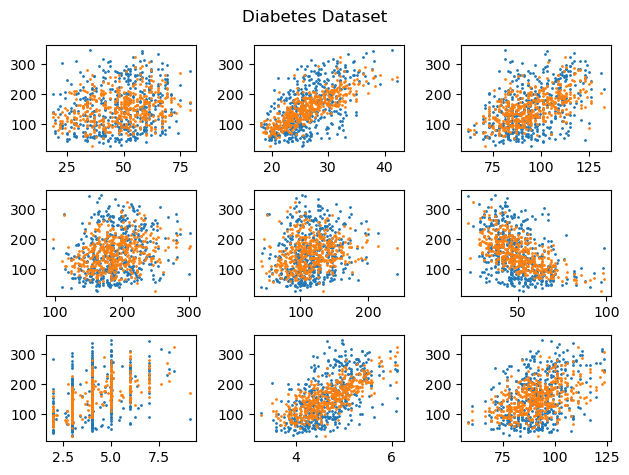

In [18]:
# Plot
fig, axs = plt.subplots(3, 3)
fig.suptitle('Diabetes Dataset')
for i in range(3):
    for j in range(3):
        n = j + i * 3
        axs[i][j].scatter(X[:, n], y, s=1)
        axs[i][j].scatter(X[:, n], model.predict(X), s=1)
plt.tight_layout()
plt.show()